In [3]:
# pretty shitty
#https://towardsdatascience.com/feature-extraction-and-similar-image-search-with-opencv-for-newbies-3c59796bf774
    
import glob
import cv2
import numpy as np
import scipy
from scipy.misc import imread
import pickle
import random
import os
import matplotlib.pyplot as plt


In [4]:
folder='/data/DAVIS/JPEGImages/480p'

In [5]:
g=glob.glob(folder+'/*/*.*')

In [35]:
favorite_color = pickle.load( open( "save.p", "rb" ) )

In [36]:
favorite_color

{}

In [52]:

# Feature extractor
def extract_features(image_path, vector_size=32):
    image = imread(image_path, mode="RGB")
    try:
        # Using KAZE, cause SIFT, ORB and other was moved to additional module
        # which is adding addtional pain during install
        alg = cv2.KAZE_create()
        # Dinding image keypoints
        kps = alg.detect(image)
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print ('Error: ', e)
        return None

    return dsc


def batch_extractor(files, pickled_db_path="features.pck"):
    #files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]

    result = {}
    for f in files:
        print ('Extracting features from image %s' % f)
        name = f
        result[name] = extract_features(f)
    
    # saving all our feature vectors in pickled file
    pickle.dump(result,  open(pickled_db_path, "wb" ))

In [53]:

class Matcher(object):

    def __init__(self, pickled_db_path="features.pck"):
        self.data =  pickle.load( open( pickled_db_path, "rb" ) )
        self.names = []
        self.matrix = []
        for k, v in self.data.items():
            self.names.append(k)
            self.matrix.append(v)
        self.matrix = np.array(self.matrix)
        self.names = np.array(self.names)

    def cos_cdist(self, vector):
        # getting cosine distance between search image and images database
        v = vector.reshape(1, -1)
        return scipy.spatial.distance.cdist(self.matrix, v, 'cosine').reshape(-1)

    def match(self, image_path, topn=5):
        features = extract_features(image_path)
        img_distances = self.cos_cdist(features)
        # getting top 5 records
        nearest_ids = np.argsort(img_distances)[:topn].tolist()
        nearest_img_paths = self.names[nearest_ids].tolist()

        return nearest_img_paths, img_distances[nearest_ids].tolist()

In [54]:
def show_img(path):
    img = imread(path, mode="RGB")
    plt.imshow(img)
    plt.show()
    




In [62]:

indices=np.random.choice(1000,100)
files = list(np.array(g)[indices])#[os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
# getting 3 random images 

batch_extractor(files)

ma = Matcher('features.pck')



Extracting features from image /data/DAVIS/JPEGImages/480p/soapbox/00088.jpg


/home/gidi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


Extracting features from image /data/DAVIS/JPEGImages/480p/bus/00039.jpg
Extracting features from image /data/DAVIS/JPEGImages/480p/bus/00067.jpg
Extracting features from image /data/DAVIS/JPEGImages/480p/dancing/00059.jpg
Extracting features from image /data/DAVIS/JPEGImages/480p/planes-water/00007.jpg
Extracting features from image /data/DAVIS/JPEGImages/480p/horsejump-low/00020.jpg
Extracting features from image /data/DAVIS/JPEGImages/480p/motocross-bumps/00035.jpg
Extracting features from image /data/DAVIS/JPEGImages/480p/horsejump-low/00040.jpg
Extracting features from image /data/DAVIS/JPEGImages/480p/stroller/00082.jpg
Extracting features from image /data/DAVIS/JPEGImages/480p/drift-turn/00011.jpg
Extracting features from image /data/DAVIS/JPEGImages/480p/planes-water/00009.jpg
Extracting features from image /data/DAVIS/JPEGImages/480p/stunt/00045.jpg
Extracting features from image /data/DAVIS/JPEGImages/480p/stroller/00029.jpg
Extracting features from image /data/DAVIS/JPEGImag

Query image ==========================================


/home/gidi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


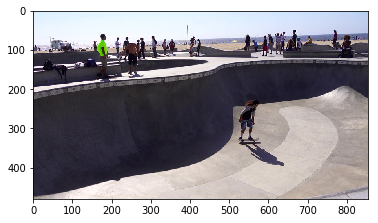

/home/gidi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


Result images ========================================
Match 1.0


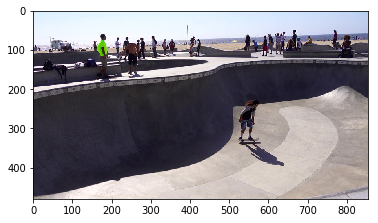

Match 0.6570199038733108


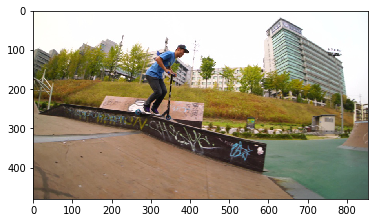

Match 0.6541373222305576


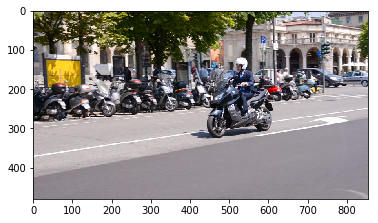

Query image ==========================================


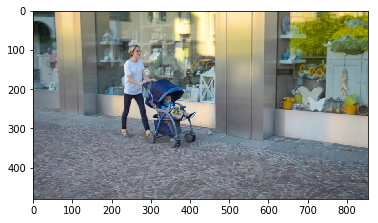

Result images ========================================
Match 0.9999999999999999


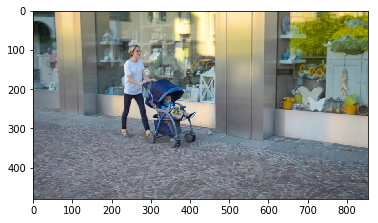

Match 0.8005324680922357


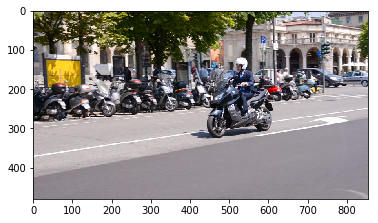

Match 0.7810565317062155


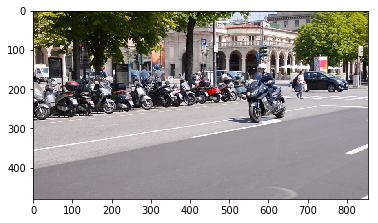

Query image ==========================================


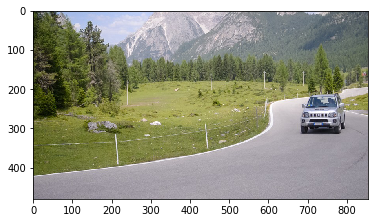

Result images ========================================
Match 0.9999999999999998


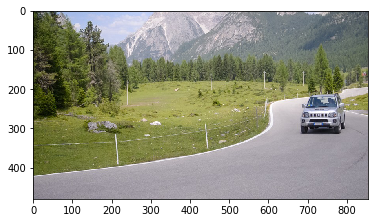

Match 0.7498294855244836


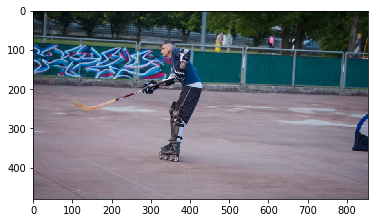

Match 0.7429252894060578


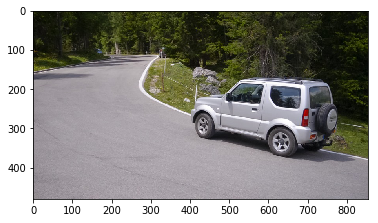

In [64]:
sample = random.sample(files, 3)

for s in sample:
    print ('Query image ==========================================')
    show_img(s)
    names, match = ma.match(s, topn=3)
    print ('Result images ========================================')
    for i in range(3):
        # we got cosine distance, less cosine distance between vectors
        # more they similar, thus we subtruct it from 1 to get match value
        print ('Match %s' % (1-match[i]))
        show_img(names[i])